<a href="https://colab.research.google.com/github/pachterlab/Clytia_single_cell_2020/blob/master/notebooks/ComparativeDistanceAnalysis/allDistanceCalculations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!date

Mon Aug 17 20:20:34 UTC 2020


In [ ]:
#Read in filtered starved data
!wget --quiet https://caltech.box.com/shared/static/glwk0aln8a3osfuffab73a47js8n0f4w
#Original clustering (CellRanger)
!wget --quiet https://caltech.box.com/shared/static/ts2i8pid7uky28kke4duyl8jwugx8z4h

#Read in filtered stimulation data 
!wget --quiet https://caltech.box.com/shared/static/hd36giuxz3zd933fh4bca3iqnykncro8

In [ ]:
#Unfiltered, raw starvation counts (Kallisto bus)
!wget --quiet https://caltech.box.com/shared/static/3l60szs0e9hgaax4q9dbuehgoo092xww

#Unfiltered, raw stimulation counts (Kallisto bus)
!wget --quiet https://caltech.box.com/shared/static/cy5n9b6rdyk7v4uhvgvpkgotmchlts45

In [ ]:
#Saved merged datasets
!wget --quiet https://caltech.box.com/shared/static/jf24fsdq7ojrbwxwf3mc7pqecnrjhpem 

# #Data only contained Fed and SW control
# !wget --quiet https://caltech.box.com/shared/static/tq6f5fqcmhw9h6kphzk8bvt5qx8xew90

In [ ]:
!pip install --quiet anndata
!pip install --quiet scanpy
!pip3 install --quiet leidenalg

     |████████████████████████████████| 122kB 12.6MB/s 
     |████████████████████████████████| 7.7MB 11.6MB/s 
     |████████████████████████████████| 71kB 8.0MB/s 
     |████████████████████████████████| 51kB 4.8MB/s 
     |████████████████████████████████| 2.4MB 12.4MB/s 
     |████████████████████████████████| 3.2MB 50.6MB/s 


###**Import packages**

In [ ]:
import pandas as pd
import anndata
import scanpy as sc
import numpy as np
import scipy.sparse

import warnings
warnings.filterwarnings('ignore')

from sklearn.neighbors import (KNeighborsClassifier,NeighborhoodComponentsAnalysis)
from sklearn.pipeline import Pipeline
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
%matplotlib inline
sc.set_figure_params(dpi=125)

import seaborn as sns
sns.set(style="whitegrid")

###**Do Distance Based Analysis for Inter- and Intra- Cluster Distances**

Read in previously saved data


In [ ]:
#bus_fs_combo data (filtered + clustered starvation (fed/starved --> fs) data)
# bus_combo_noZero (filtered + clustered stimulation data) from Kallisto bus

#bus_fs_combo
bus_fs_combo = anndata.read("glwk0aln8a3osfuffab73a47js8n0f4w")

print(bus_fs_combo)

bus_combo_noZero = anndata.read("hd36giuxz3zd933fh4bca3iqnykncro8")
print(bus_combo_noZero)

#Previously saved overlap, merged data (from both experiments)
overlap_combo = anndata.read("jf24fsdq7ojrbwxwf3mc7pqecnrjhpem")
overlap_combo

AnnData object with n_obs × n_vars = 13673 × 8696
    obs: 'batch', 'n_counts', 'n_countslog', 'louvain', 'leiden', 'orgID', 'fed', 'starved', 'fed_neighbor_score', 'cellRanger_louvain', 'annos', 'new_cellRanger_louvain', 'annosSub'
    var: 'n_counts', 'mean', 'std'
    uns: 'annosSub_colors', 'annos_colors', 'cellRanger_louvain_colors', 'cellRanger_louvain_sizes', "dendrogram_['new_cellRanger_louvain']", 'dendrogram_new_cellRanger_louvain', 'fed_colors', 'fed_neighbor_score_colors', 'leiden', 'leiden_colors', 'louvain', 'louvain_colors', 'neighbors', 'new_cellRanger_louvain_colors', 'orgID_colors', 'paga', 'pca', 'rank_genes_groups', 'umap'
    obsm: 'X_nca', 'X_pca', 'X_tsne', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'
AnnData object with n_obs × n_vars = 19054 × 10260
    obs: 'batch', 'n_counts', 'n_countslog', 'leiden', 'condition', 'orgID', 'cellRanger_louvain'
    var: 'n_counts'
    uns: 'cellRanger_louvain_colors', 'cellRanger_louvain_sizes', 'condition_

AnnData object with n_obs × n_vars = 32727 × 6756
    obs: 'batch', 'condition', 'fed', 'fed_neighbor_score', 'leiden', 'louvain', 'n_counts', 'n_countslog', 'orgID', 'starved', 'knn_clus', 'cell_origin'
    var: 'n_counts-0', 'n_counts-1'
    uns: 'cell_origin_colors', 'draw_graph', 'knn_clus_colors', 'knn_clus_sizes', 'neighbors', 'paga', 'pca'
    obsm: 'X_draw_graph_fa', 'X_nca', 'X_pca', 'X_tsne'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [ ]:
#How raw overlap adata was made (no genes filtered out)
bus_fs_raw = anndata.read("3l60szs0e9hgaax4q9dbuehgoo092xww")

bus_stim_raw = anndata.read("cy5n9b6rdyk7v4uhvgvpkgotmchlts45")

#Merge datasets
bus_fs_raw.obs_names = [i+'_fs' for i in bus_fs_raw.obs_names]
bus_stim_raw.obs_names = [i+'_ieg' for i in bus_stim_raw.obs_names]

raw_overlap_combo = bus_fs_raw.concatenate(bus_stim_raw,join='outer', index_unique=None)

Predict labels for stimulation data


In [ ]:
#Make X_pca with merged, use top n PC's
def getPredLabels(overlap_fs,overlap_combo, n_PC):
    
    numFS = len(overlap_fs.obs_names)
    X_train = overlap_combo.obsm['X_pca'][0:numFS,0:n_PC]

    #X_pca at stim rows = X_test
    X_test = overlap_combo.obsm['X_pca'][numFS:,0:n_PC]

    #y_train is f/s louvain labels
    y_train = overlap_fs.obs['cellRanger_louvain']

    #Fit and predict
    classifier = KNeighborsClassifier(n_neighbors=15)
    classifier.fit(X_train, y_train)

    y_pred = classifier.predict(X_test)
    
    labels = list(y_train)+list(y_pred)
    
    print(len(labels),' labels created')
    
    return labels


#### **How merged dataset (joint-PC space) with stimulation and starvation experiments was made (= overlap_combo)**


In [ ]:
#Get intersection of var names between the two (making overlap_combo)
overlap = list(set(bus_combo_noZero.var_names).intersection(bus_fs_combo.var_names))

overlap_fs = bus_fs_combo[:,overlap]

overlap_stim = bus_combo_noZero[:,overlap]


#Merge datasets
overlap_fs.obs_names = [i+'_fs' for i in overlap_fs.obs_names]
overlap_stim.obs_names = [i+'_ieg' for i in overlap_stim.obs_names]

origin = list(np.repeat('FS',len(overlap_fs.obs_names))) + list(np.repeat('Stim',len(overlap_stim.obs_names)))
overlap_combo = overlap_fs.concatenate(overlap_stim,join='outer', index_unique=None)

overlap_combo.obs['cell_origin'] = pd.Categorical(origin)
sc.pp.scale(overlap_combo, max_value=10)

#Do PCA on merged dataset + plot variance explained
sc.tl.pca(overlap_combo, n_comps=60)
#sc.pl.pca_variance_ratio(overlap_combo, log=True)

#overlap_combo

labels = getPredLabels(overlap_fs,overlap_combo,n_PC = 60)

overlap_combo.obs['knn_clus'] = pd.Categorical(labels)


32727  labels created


#### **Plot percent of K neighbors for each stim cell that are in one unique cluster**

In [ ]:
from sklearn.neighbors import NearestNeighbors
import random 

#Read in previously saved data
#overlap_combo = anndata.read("jf24fsdq7ojrbwxwf3mc7pqecnrjhpem")

n = 15

neigh = NearestNeighbors(n_neighbors=n)
n_PC = 60


numFS = len(overlap_fs.obs_names)
X_train = overlap_combo.obsm['X_pca'][0:numFS,0:n_PC]

#X_pca at stim rows = X_test
X_test = overlap_combo.obsm['X_pca'][numFS:,0:n_PC]

#y_train is f/s louvain labels
y_train = overlap_fs.obs['cellRanger_louvain']

#Fit and predict
#neigh.fit(X_train)


#Subsample 70% of fed/starved data for training, test on remaining 30% and stim data
numSamp = np.int(0.7*X_train.shape[0])
ind = random.sample(range(0,X_train.shape[0]),numSamp)
allInd = range(0,X_train.shape[0])
rest = [i for i in allInd if i not in ind]

#Fit and predict
neigh.fit(X_train[ind,:])

X_rest = X_train[rest,:]



fsNeigh = neigh.kneighbors(X_rest)
stimNeigh = neigh.kneighbors(X_test)



In [ ]:
y_train = y_train[ind]

In [ ]:
stim_neighbors = stimNeigh[1]
fs_neighbors = fsNeigh[1]

#y_train = y_train[ind]
stim_perc = np.zeros(stim_neighbors.shape[0])
for i in range(0,len(stim_perc)): 
  #How many of top neighbors come from same cluster in fed/starved data (out of n=15)
  stim_perc[i] = np.max(y_train[stim_neighbors[i]].value_counts())/n 

fs_perc = np.zeros(fs_neighbors.shape[0])
#y_train = y_train[ind]
for i in range(0,len(fs_perc)): 
  fs_perc[i] = np.max(y_train[fs_neighbors[i]].value_counts())/n


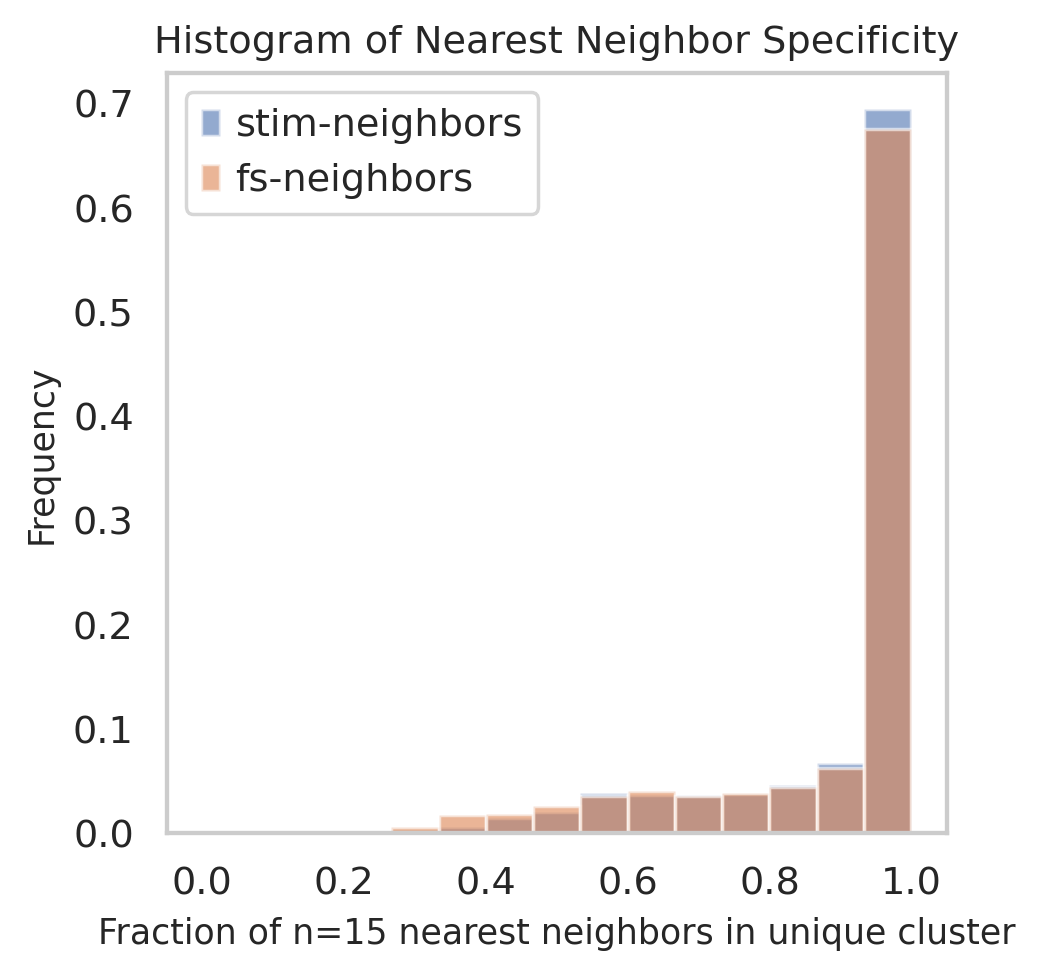

In [ ]:
plt.hist(stim_perc,density=False,range=(0,1),alpha=0.6 ,bins=15,weights=np.ones(len(stim_perc))/len(stim_perc),label='stim-neighbors')
plt.hist(fs_perc,density=False,range=(0,1),alpha=0.6 ,bins=15 ,weights=np.ones(len(fs_perc))/len(fs_perc),label='fs-neighbors')
plt.legend(loc='upper left')
plt.title('Histogram of Nearest Neighbor Specificity',fontsize=11)
plt.grid(b=None)
plt.xlabel("Fraction of n=15 nearest neighbors in unique cluster",fontsize=10)
plt.ylabel("Frequency",fontsize=10)
plt.show()

####**Determine Inter and Intra Cluster Distances (perturbation effect vs cell type distance)**

In [ ]:
#Plot distances between centroid of stim-starved and fed-starved for each cluster
def changeBool(fed):
    if fed == 'True':
        return 'fed'
    elif fed == 'False':
        return 'starved' 
    else:
        return 'stim'

def addConds(overlap_combo):
    fs_conds = [changeBool(i) for i in overlap_combo.obs['fed']]
    overlap_combo.obs['centroid_conds'] = pd.Categorical(fs_conds)

    overlap_combo.obs['centroid_conds']

In [ ]:
from sklearn.metrics import pairwise_distances
#Centroids of cell atlas/defined clusters
def getClusCentroids(overlap_combo,pcs=60,clusType='knn_clus'):
    clusters = np.unique(overlap_combo.obs[clusType])
    centroids = np.zeros((len(clusters),pcs))
    
    for c in clusters:
        
        sub_data = overlap_combo[overlap_combo.obs[clusType] == c]
        pca_embed = sub_data.obsm['X_pca'][:,0:pcs]
        centroid = pca_embed.mean(axis=0)
        
        centroids[c,:] = list(centroid)
        
    return centroids

In [ ]:
#Distance between conditions within clusters
def getCentroidDists(overlap_combo,pcs=60,clusType='knn_clus'):
    fedStarv = []
    fsStim = []

    cluster = []

    #Initialize output matrix
    addConds(overlap_combo)
    clusters = np.unique(overlap_combo.obs[clusType])
    centroid_dist = pd.DataFrame(columns =['fedStarv','fsStim','cluster','clus_color']) 

    for c in clusters:
        #Get cells in cluster and their conditions
        sub_data = overlap_combo[overlap_combo.obs[clusType] == c]
        centroid_conds = sub_data.obs['centroid_conds'] 

        #Get 2D tsne embedding
        pca_embed = sub_data.obsm['X_pca'][:,0:pcs] #PCA

        #Get location of condition cells
        stim_pos = list(centroid_conds == 'stim')
        allFS_pos = list(centroid_conds != 'stim')
        fed_pos = list(centroid_conds == 'fed')
        starved_pos = list(centroid_conds == 'starved')

        #Get column means for x,y coords
        meanFed = pca_embed[fed_pos,].mean(axis=0)

        meanStarv = pca_embed[starved_pos,].mean(axis=0)

        meanStim = pca_embed[stim_pos,].mean(axis=0)

        meanFS = pca_embed[allFS_pos,].mean(axis=0)


        cluster += [c]

        #Dist between fed and starved
        fs_dist = np.linalg.norm(meanFed - meanStarv,1)

        #Dist between (all) starved experiment and stim

        starvStim_dist = np.linalg.norm(meanFS - meanStim,1)

        fedStarv += [fs_dist]
        fsStim += [starvStim_dist]

    centroid_dist['fedStarv'] = fedStarv
    centroid_dist['fsStim'] = fsStim

    centroid_dist['cluster'] = cluster

    return centroid_dist

In [ ]:
#Distance between conditions within clusters
def getStimCentroidDists(overlap_combo,pcs=60,clusType='knn_clus'):
    swKCl = []
    swDI = []

    cluster = []

    #Initialize output matrix
    #addConds(overlap_combo)
    clusters = np.unique(overlap_combo.obs[clusType])
    centroid_dist = pd.DataFrame(columns =['swKCl','swDI','cluster','clus_color']) 

    for c in clusters:
        #Get cells in cluster and their conditions
        sub_data = overlap_combo[overlap_combo.obs[clusType] == c]
        centroid_conds = sub_data.obs['condition'] 

        #Get 2D tsne embedding
        pca_embed = sub_data.obsm['X_pca'][:,0:pcs] #PCA

        #Get location of condition cells
        sw_pos = list(centroid_conds == 'SW')
        kcl_pos = list(centroid_conds == 'KCl')
        di_pos = list(centroid_conds == 'DI')
        

        #Get column means for x,y coords
        meanSW = pca_embed[sw_pos,].mean(axis=0)

        meanKCl = pca_embed[kcl_pos,].mean(axis=0)

        meanDI = pca_embed[di_pos,].mean(axis=0)




        cluster += [c]

        #Dist between fed and starved
        swKCl_dist = np.linalg.norm(meanSW - meanKCl,1)

        #Dist between (all) starved experiment and stim

        swDI_dist = np.linalg.norm(meanSW - meanDI,1)

        swKCl += [swKCl_dist]
        swDI += [swDI_dist]

    centroid_dist['swKCl'] = swKCl 
    centroid_dist['swDI'] =  swDI

    centroid_dist['cluster'] = cluster

    return centroid_dist

#####**Fed/Starved and Stimulation (Separate) Analysis**
Cell type v state plots

In [ ]:
withinFS_Dists = getCentroidDists(bus_fs_combo,60,'cellRanger_louvain')
withinFS_Dists.head()

,fedStarv,fsStim,cluster,clus_color
0,11.357661,NaN,0,NaN
1,17.776861,NaN,1,NaN
2,12.411180,NaN,2,NaN
3,18.126976,NaN,3,NaN
4,13.799874,NaN,4,NaN


In [ ]:
#Compare to pairwise distances between cell atlas clusters
centroids = getClusCentroids(bus_fs_combo,60,'cellRanger_louvain')
#centroids_arr = centroids['centroid'].to_numpy()
pairCentroid_dists = pairwise_distances(centroids, metric = 'l1')
pairCentroid_dists.shape
print(np.mean(pairCentroid_dists))

150.34457080272998


In [ ]:
np.unique(bus_fs_combo.obs['cellRanger_louvain'])

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35])

In [ ]:
#Early cnidocytes, germ cells, stem cells have distances that overlap with intra-F/S distances for 14&19
np.where(pairCentroid_dists < 60.79)

(array([ 0,  0,  1,  2,  2,  3,  3,  4,  5,  6,  7,  7,  8,  9, 10, 11, 12,
        12, 13, 14, 15, 16, 17, 18, 19, 20, 20, 21, 22, 23, 24, 25, 26, 27,
        28, 29, 30, 31, 32, 33, 34, 35]),
 array([ 0, 12,  1,  2, 20,  3,  7,  4,  5,  6,  3,  7,  8,  9, 10, 11,  0,
        12, 13, 14, 15, 16, 17, 18, 19,  2, 20, 21, 22, 23, 24, 25, 26, 27,
        28, 29, 30, 31, 32, 33, 34, 35]))

49.54310559108853


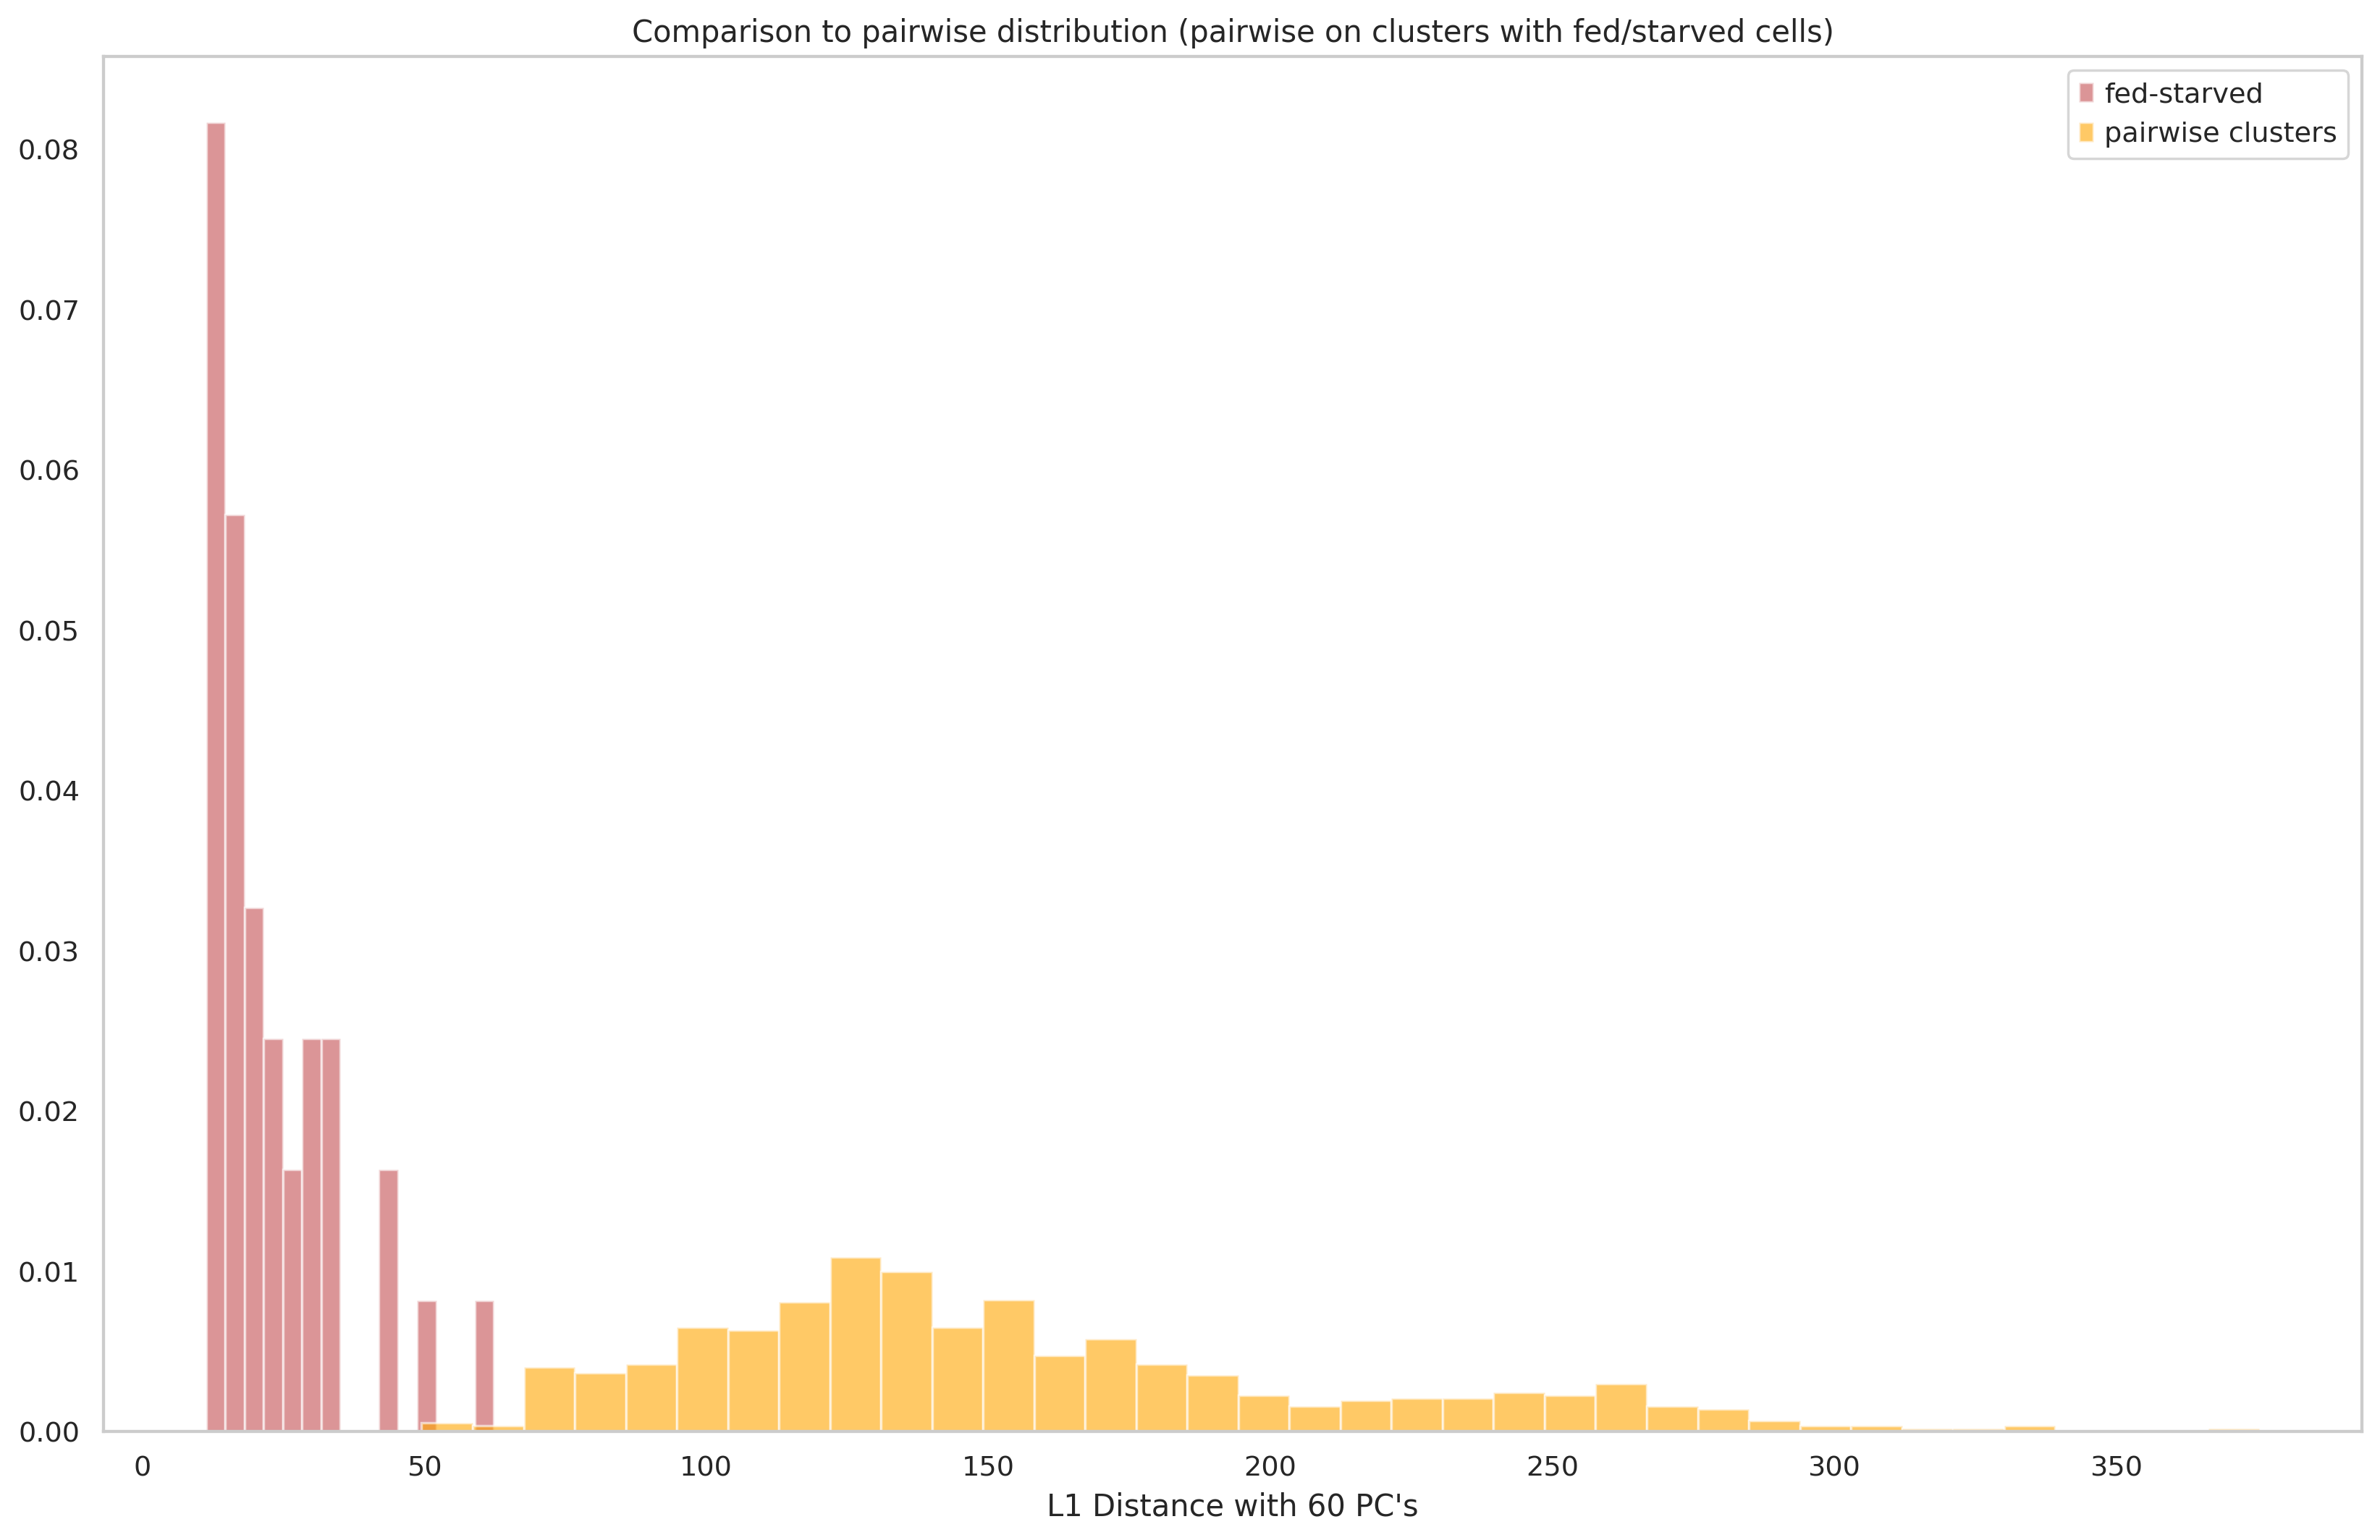

In [ ]:
max(pairCentroid_dists.reshape((36*36,)))
reshape_noZero = [i for i in pairCentroid_dists.reshape((36*36,)) if i != 0]
print(np.min(reshape_noZero))

plt.figure(figsize=(16,10))
plt.hist(withinFS_Dists['fedStarv'],color='r',bins=15,alpha=0.6,label='fed-starved',density=True)

plt.hist(reshape_noZero, bins=36,color = 'orange',alpha=0.6,label='pairwise clusters',density=True)
plt.legend(loc='upper right')
plt.title('Comparison to pairwise distribution (pairwise on clusters with fed/starved cells)')
plt.grid(b=None)
plt.xlabel("L1 Distance with 60 PC's")
plt.show()

In [ ]:
#Area where line between cell state/type is blurred seems to be only in digestive endodermal clusters 14,19 (strong metabolic responses to starvation)
outlier_clus = withinFS_Dists[withinFS_Dists.fedStarv> 46.69]['cluster']
outlier_clus


14    14
19    19
Name: cluster, dtype: int64

Compare internal distances to differences in numbers of fed & starved cells (Spearman Rank correlation)

In [ ]:
#Composition of broad cell types between fed and starved , cell counts
counts = pd.DataFrame(columns =['count', 'orgID','condition','cluster']) 
clusters = np.unique(bus_fs_combo.obs['cellRanger_louvain'])

c = []
org = []
cond = []
clus = []

orgs = np.unique(bus_fs_combo.obs['orgID'])
conds = ['True', 'False']
for cl in clusters:
    data = bus_fs_combo[bus_fs_combo.obs['cellRanger_louvain'].isin([cl])]
    
    for cd in conds:
        #c_data = data[data.obs['condition'].isin([cd])]
        
        for o in orgs:
            pos = (data.obs['fed'].isin([cd])) & (data.obs['orgID'].isin([o]))
            org_data = data[pos]
            c += [org_data.n_obs]
            org += [o]
            if cd == 'True':
              cond += ['fed']
            else:
              cond += ['starved']
            clus += [cl]
            
                
print(len(c))


   
    
counts['count'] = c
counts['orgID'] = org
counts['condition'] = cond
counts['cluster'] = clus

720


In [ ]:
counts = counts[counts['count']> 0 ]
counts.head()

,count,orgID,condition,cluster
0,118,1,fed,0
2,83,2,fed,0
3,102,3,fed,0
4,102,4,fed,0
5,118,5,fed,0


In [ ]:
#One-way anova for each cluster
pvalsFTest = {}

for cl in clusters:
  sub = counts[counts.cluster == cl]
  subFed = sub[sub.condition == 'fed']
  subStarv = sub[sub.condition == 'starved']

  fedVals = list(subFed['count'])
  starvVals = list(subStarv['count'])

  pvalsFTest[cl] = scipy.stats.f_oneway(fedVals,starvVals)

In [ ]:
import statsmodels.stats as sm
pvals = []
# sizes = [] 
for c in clusters:
  pvals += [pvalsFTest[c][1]] 
  # sizes += [len(bus_fs_combo[bus_fs_combo.obs['cellRanger_louvain'].isin([c])].obs_names)]

pvals = sm.multitest.fdrcorrection(pvals,alpha=0.05, method='indep')
pvals

(array([False, False, False, False, False, False, False, False, False,
        False,  True, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False]),
 array([1.64253441e-01, 9.35522778e-01, 5.21386720e-01, 8.07361578e-01,
        9.97826979e-01, 3.31498471e-01, 8.07361578e-01, 5.68508228e-01,
        6.91908915e-01, 5.34369937e-01, 4.49408286e-04, 1.99877010e-01,
        9.63535360e-01, 7.78106033e-01, 2.25187596e-01, 4.82880690e-01,
        6.42595657e-01, 4.19543898e-01, 6.87698796e-01, 9.35522778e-01,
        3.31498471e-01, 9.63535360e-01, 9.63535360e-01, 3.31498471e-01,
        3.31498471e-01, 9.97826979e-01, 4.82880690e-01, 1.64253441e-01,
        4.82880690e-01, 2.09527206e-01, 4.82880690e-01, 3.31498471e-01,
        9.63535360e-01, 1.64253441e-01, 9.35522778e-01, 1.00000000e+00]))

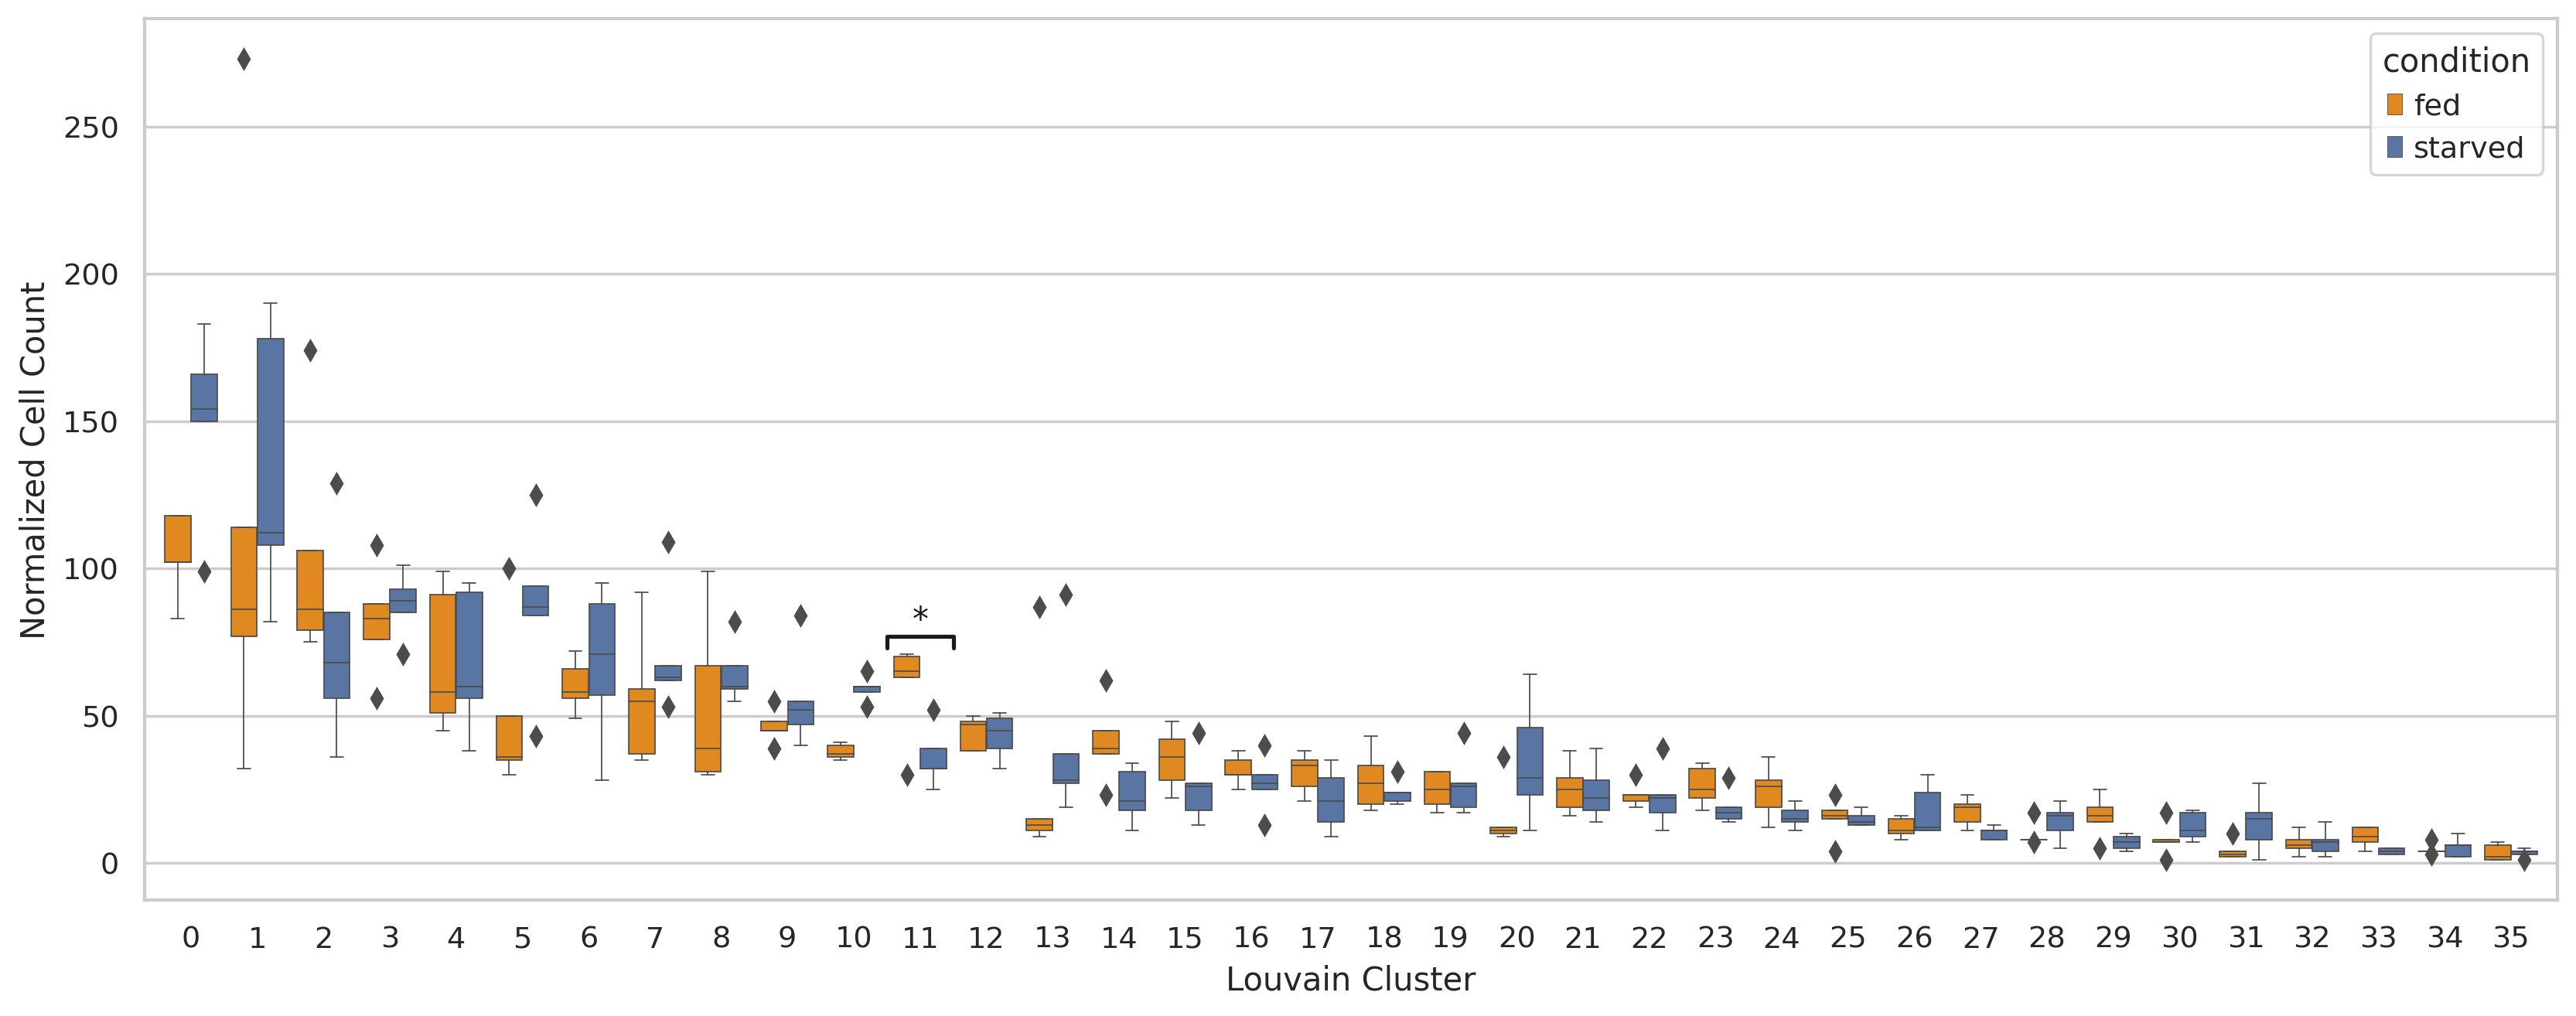

In [ ]:
#counts = counts[counts['count']> 0 ]
#https://stackoverflow.com/questions/36578458/how-does-one-insert-statistical-annotations-stars-or-p-values-into-matplotlib/37518947#37518947

counts['cluster'] = [int(i) for i in counts['cluster']] 
plt.figure(figsize=(16, 6))
ax = sns.boxplot(x="cluster", y="count", hue="condition", data=counts,linewidth=0.5,palette=["darkorange", "b"])
ax.set(ylabel='Normalized Cell Count')
ax.set(xlabel='Louvain Cluster')

# statistical annotation
# alpha < 0.05
for i in [11]: 
  w = 0.5
  x1, x2 = i-w,i+w  

  y, h, col = counts['count'][counts['cluster'] == i].max() + 2, 4, 'k'
  plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
  plt.text((x1+x2)*.5, y+h, "*", ha='center', va='bottom', color=col)


plt.show()



In [ ]:
internalDist = list(withinFS_Dists['fedStarv'])

In [ ]:
scipy.stats.spearmanr(internalDist,pvals[1])

SpearmanrResult(correlation=-0.050871795043468955, pvalue=0.768261688241116)

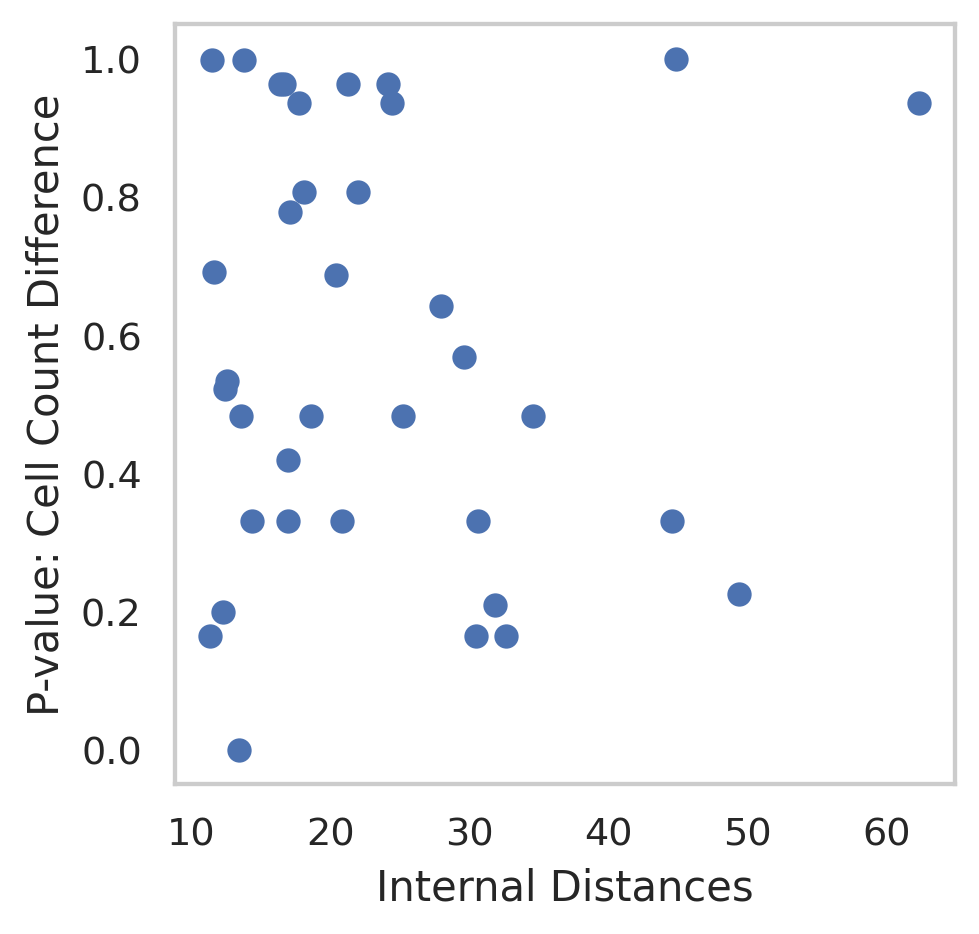

In [ ]:
plt.scatter(internalDist,pvals[1])
plt.xlabel('Internal Distances')
plt.ylabel('P-value: Cell Count Difference')
plt.grid(None)

In [ ]:
counts.to_csv('individ_cellCounts.csv',index=None)

####**Repeat for Stimulation Data**

In [ ]:
bus_combo_noZero.obs['cellRanger_louvain'] = pd.Categorical(overlap_combo[overlap_combo.obs['cell_origin'] == 'Stim'].obs['knn_clus'])

In [ ]:
withinStim_Dists = getStimCentroidDists(bus_combo_noZero,60,'cellRanger_louvain')
withinStim_Dists

,swKCl,swDI,cluster,clus_color
0,6.534549,7.460227,0,NaN
1,29.090990,32.264286,1,NaN
2,18.313423,16.736040,2,NaN
3,17.085300,34.973236,3,NaN
4,16.697495,29.665161,4,NaN
5,18.261822,34.310585,5,NaN
6,18.664618,31.322338,6,NaN
7,12.972950,21.345463,7,NaN
8,12.331634,34.677486,8,NaN
9,17.886221,22.465418,9,NaN


In [ ]:
#Compare to pairwise distances between cell atlas clusters
centroids = getClusCentroids(bus_combo_noZero,60,'cellRanger_louvain')
#centroids_arr = centroids['centroid'].to_numpy()
pairCentroid_dists = pairwise_distances(centroids, metric = 'l1')
pairCentroid_dists.shape
print(np.mean(pairCentroid_dists))

182.01552522903225


In [ ]:
#withinStim_Dists['swDI']
print(np.max(withinStim_Dists))

swKCl         74.751534
swDI          64.399223
cluster       35.000000
clus_color          NaN
dtype: float64


In [ ]:
print(np.where(pairCentroid_dists < 74.75))

(array([ 0,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 12, 13, 14,
       15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31,
       32, 33, 34, 35]), array([ 0, 12,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11,  0, 12, 13, 14,
       15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31,
       32, 33, 34, 35]))


73.29024843219668


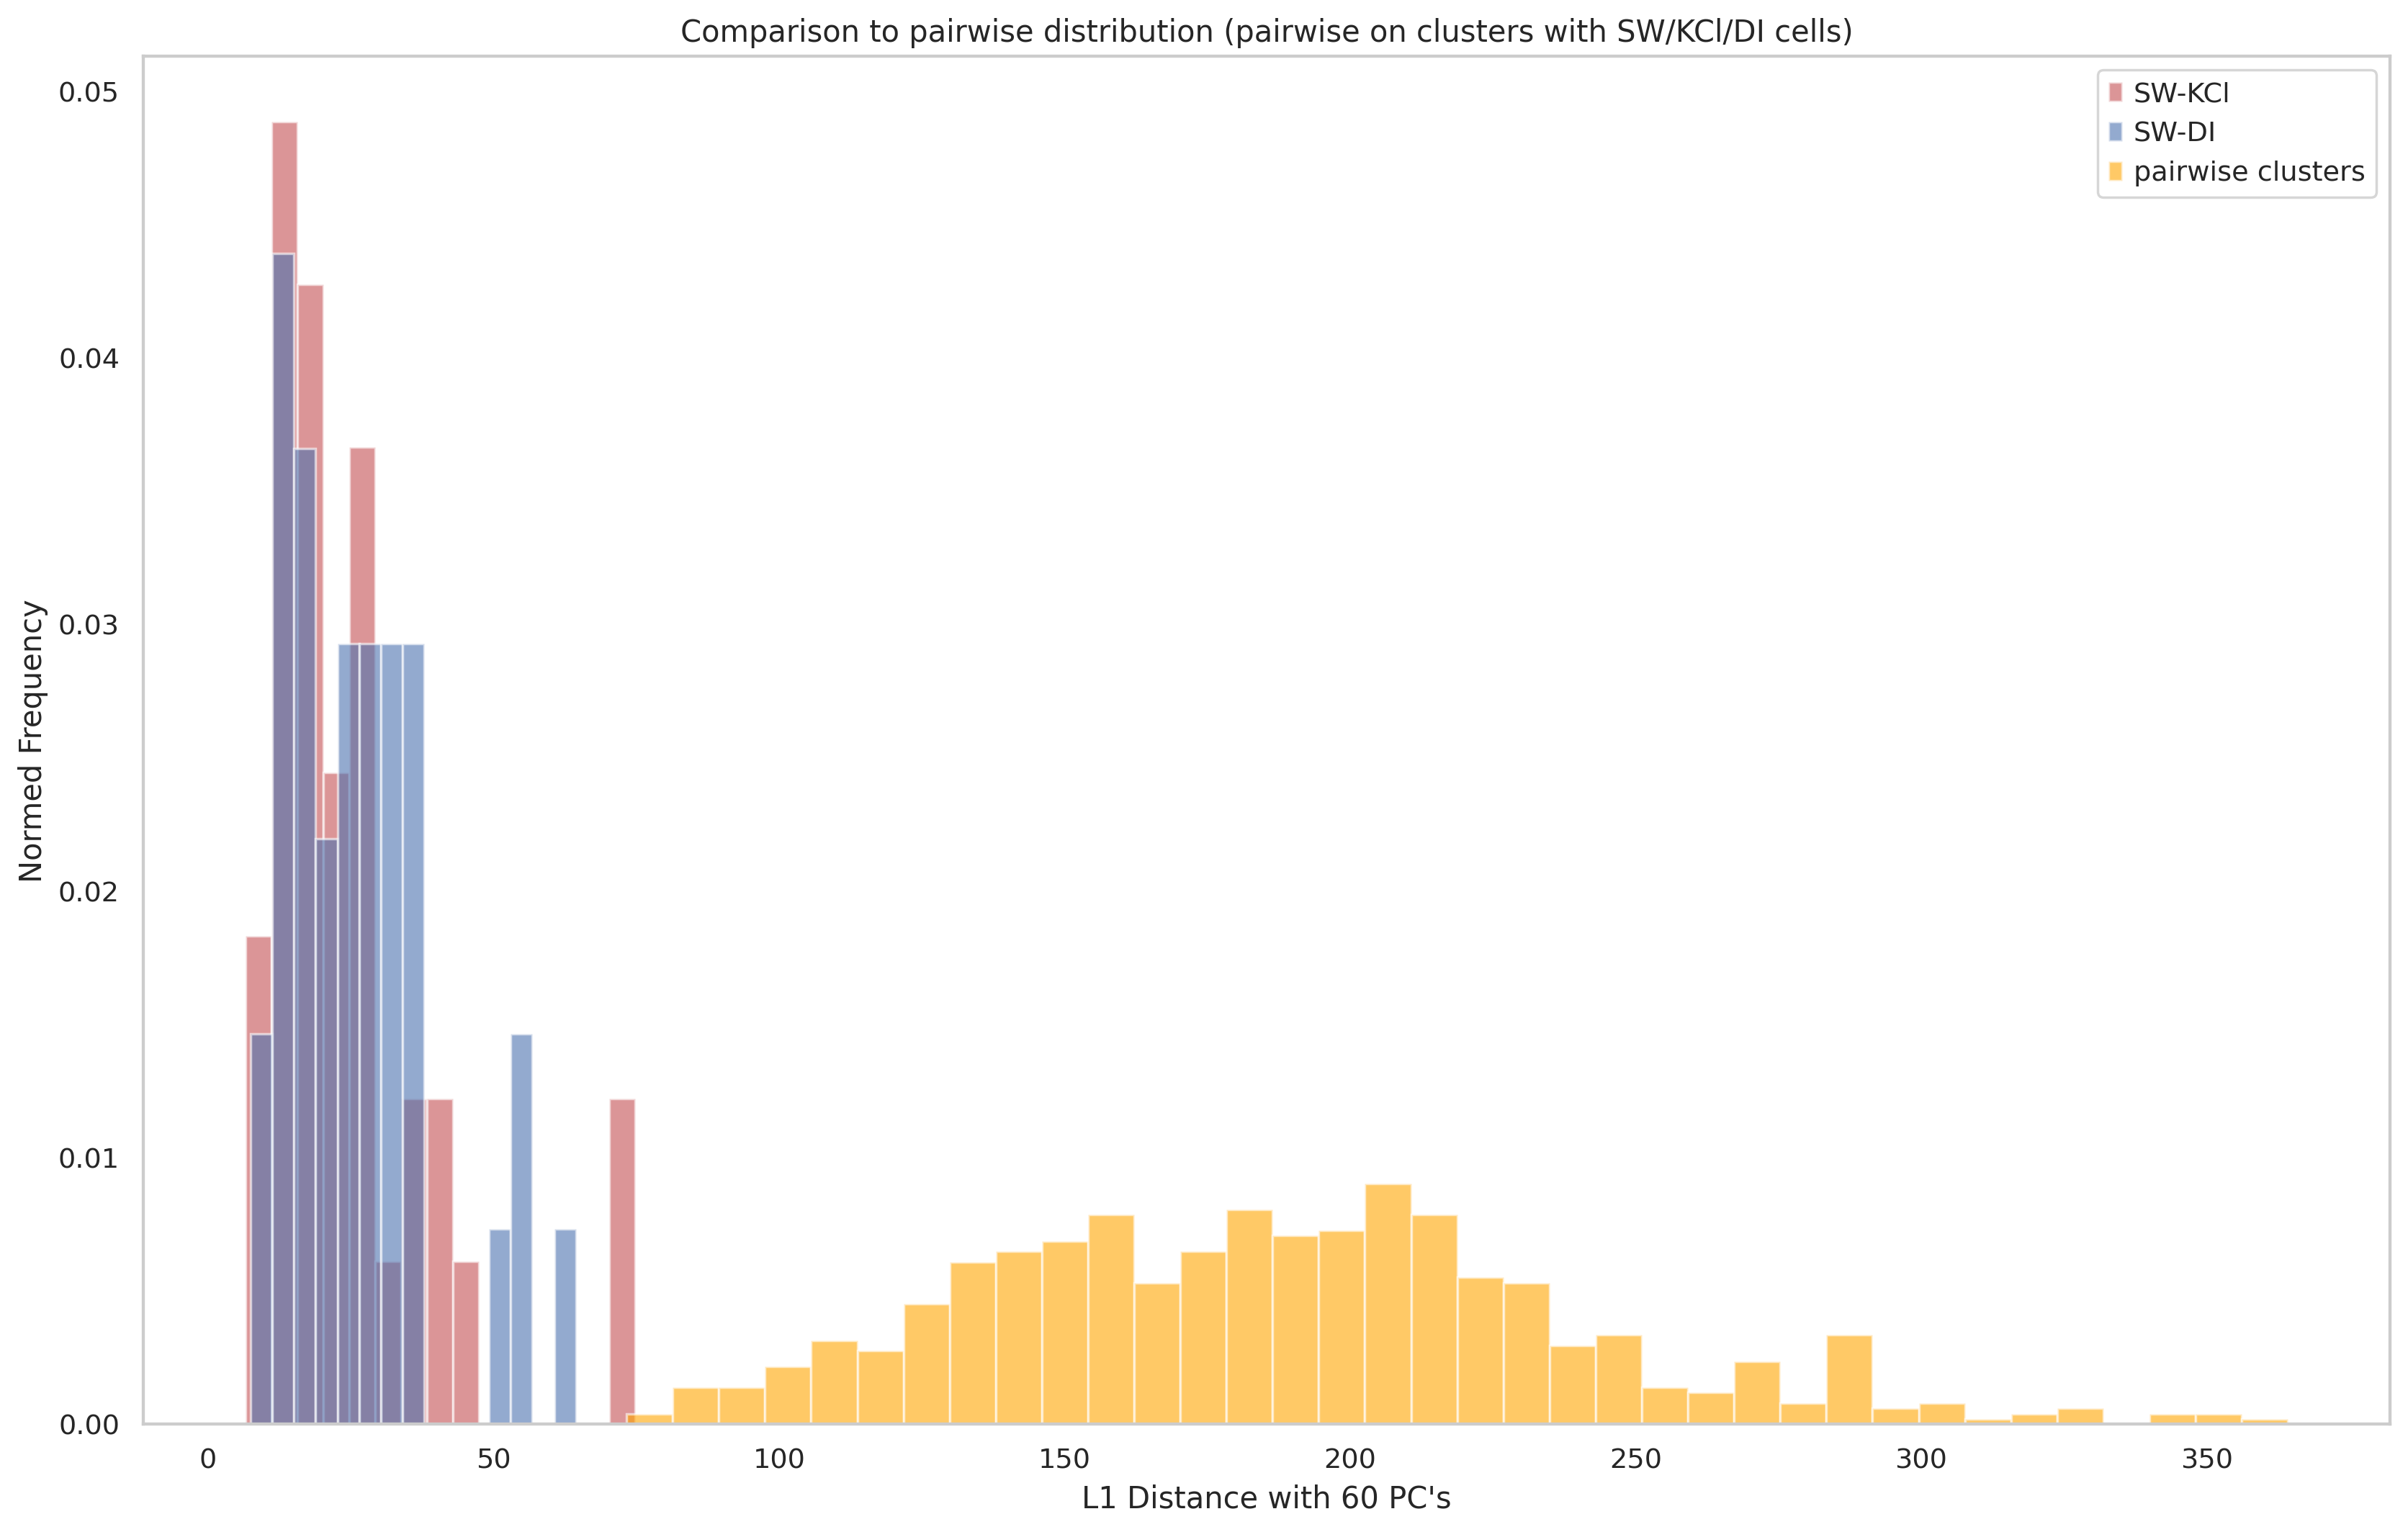

In [ ]:
max(pairCentroid_dists.reshape((36*36,)))
reshape_noZero = [i for i in pairCentroid_dists.reshape((36*36,)) if i != 0]
print(np.min(reshape_noZero))

plt.figure(figsize=(16,10))
plt.hist(withinStim_Dists['swKCl'],color='r',bins=15,alpha=0.6,label='SW-KCl',density=True)
plt.hist(withinStim_Dists['swDI'],color='b',bins=15,alpha=0.6,label='SW-DI',density=True)

plt.hist(reshape_noZero, bins=36,color = 'orange',alpha=0.6,label='pairwise clusters',density=True)
plt.legend(loc='upper right')
plt.title('Comparison to pairwise distribution (pairwise on clusters with SW/KCl/DI cells)')

plt.xlabel("L1 Distance with 60 PC's")
plt.ylabel("Normed Frequency")
plt.grid(b=None)
plt.show()

####**Organismal Distances, Fed/Starved + Stimulation**
Batch effect plots

In [ ]:
#condition -- Stim, fed -- Fed/Starved data
overlap_combo

AnnData object with n_obs × n_vars = 32727 × 6756
    obs: 'batch', 'condition', 'fed', 'fed_neighbor_score', 'leiden', 'louvain', 'n_counts', 'n_countslog', 'orgID', 'starved', 'knn_clus', 'cell_origin'
    var: 'n_counts-0', 'n_counts-1'
    uns: 'cell_origin_colors', 'draw_graph', 'knn_clus_colors', 'knn_clus_sizes', 'neighbors', 'paga', 'pca'
    obsm: 'X_draw_graph_fa', 'X_nca', 'X_pca', 'X_tsne'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [ ]:
#Use overlap_combo

#Go through each clustee
clus = np.unique(overlap_combo.obs['knn_clus'])

fed_data = overlap_combo[overlap_combo.obs['fed'] == 'True']
sw_data = overlap_combo[overlap_combo.obs['condition'] == 'SW']

fed_orgs = np.unique(fed_data.obs['orgID'])
sw_orgs = np.unique(sw_data.obs['orgID'])

pcs = 60

org_metadata = pd.DataFrame(columns =['orgID','cluster','condition']) #centroid = row mean for all cells in organism
num_points = (len(fed_orgs)+len(sw_orgs))*len(clus)

#Get centroid in PCA space in each cluster for each organism
org_centroids = np.zeros((num_points,pcs))

condition = []
cluster = []
orgID = []

count = 0
toRemove = []
for c in clus:
  #Get all cells in chosen condition
  fed_sub = fed_data[fed_data.obs['knn_clus'] == c]
  fed_pca_embed = fed_sub.obsm['X_pca'][:,0:pcs] #PCA matrix

  sw_sub = sw_data[sw_data.obs['knn_clus'] == c]
  sw_pca_embed = sw_sub.obsm['X_pca'][:,0:pcs] #PCA matrix

  #For each org, get centroid of cells (X_pca)
  for sw in sw_orgs:
    condition += ['SW']
    cluster += [c]
    orgID += [sw]

    #Get location of org cells
    org_pos = list(sw_sub.obs['orgID'] == sw)

    #Sum down rows of cells for each PC
    if len(sw_pca_embed[org_pos,]) == 0:
      toRemove += [count]

    org_centroids[count,:] = list(sw_pca_embed[org_pos,].mean(axis=0))

    count += 1

  for fed in fed_orgs:
    condition += ['Fed']
    cluster += [c]
    orgID += [fed]

    #Get location of org cells
    org_pos = list(fed_sub.obs['orgID'] == fed)
    #Sum down rows of cells for each PC
    if len(fed_pca_embed[org_pos,]) == 0:
      toRemove += [count]

    org_centroids[count,:] = list(fed_pca_embed[org_pos,].mean(axis=0))

    count += 1    

  #For each org, get centroid of cells (X_pca)

  #Average pairwise distance between org centroid

org_metadata['orgID'] = orgID
org_metadata['cluster'] = cluster
org_metadata['condition'] = condition




In [ ]:
toRemove 

[181, 183]

In [ ]:
org_metadata = org_metadata.drop(org_metadata.index[toRemove])
org_metadata.head()

org_centroids= np.delete(org_centroids, toRemove, 0)
org_centroids[0,:]

array([-2.5141046 , -1.83165169, -2.56139255, -0.30813822,  1.98264134,
       -1.87403417, -3.38868713, -0.13224465, -2.21397758, -1.29323554,
       -1.94140637, -1.32937133, -3.10828853,  0.80791473,  1.62436104,
       -0.25122994, -0.1887034 , -0.0583187 ,  0.72272348, -3.10565209,
        4.24892616,  0.37986624, -0.55612922,  0.59272265,  1.71611094,
        0.18304156, -0.49343768, -0.86163104,  0.33055994, -0.709203  ,
        0.56443644,  0.82765633, -0.53927851, -0.98591512, -0.33037487,
       -0.26226798, -0.02119251, -0.54339862, -0.05480121, -0.18422647,
        1.82246745,  0.5512197 , -0.12327559, -0.62353981,  0.45485938,
        0.32711661,  0.760185  ,  0.3137255 ,  0.22211218,  0.23228893,
        0.12949443,  0.16719288, -0.71052462, -0.33989388,  0.3274518 ,
       -0.18515548,  0.48728189,  0.23112439,  0.46149072, -0.40837356])

In [ ]:
org_pairDists = pd.DataFrame(columns =['cluster','pair_fed','pair_sw','pair_mix'])
cluster = []
pair_fed = []
pair_sw = []
pair_mix = []

for c in clus:

  #Fed org centroids
  where_fed = (org_metadata.cluster == c) & (org_metadata.condition == 'Fed')
  fed_mat = org_centroids[where_fed,:]

  pair_fed_dist = pairwise_distances(fed_mat, metric = 'l1')
  pair_fed_mean = np.mean(pair_fed_dist)

  #SW org centroids
  where_sw = (org_metadata.cluster == c) & (org_metadata.condition == 'SW')
  sw_mat = org_centroids[where_sw,:]

  pair_sw_dist = pairwise_distances(sw_mat, metric = 'l1')
  pair_sw_mean = np.mean(pair_sw_dist)

  pair_mix_dist = pairwise_distances(fed_mat,sw_mat, metric = 'l1')
  pair_mix_mean = np.mean(pair_mix_dist)

  cluster += [c]
  pair_fed += [pair_fed_mean]
  pair_sw += [pair_sw_mean]
  pair_mix += [pair_mix_mean]

org_pairDists['cluster'] = cluster
org_pairDists['pair_fed'] = pair_fed
org_pairDists['pair_sw'] = pair_sw
org_pairDists['pair_mix'] = pair_mix

In [ ]:
org_pairDists.head()

,cluster,pair_fed,pair_sw,pair_mix
0,0,6.435431,6.709091,23.432679
1,1,14.112677,34.774560,63.872450
2,2,8.279761,14.382547,53.206116
3,3,17.876802,26.969492,54.635241
4,4,15.024401,24.717512,34.451474


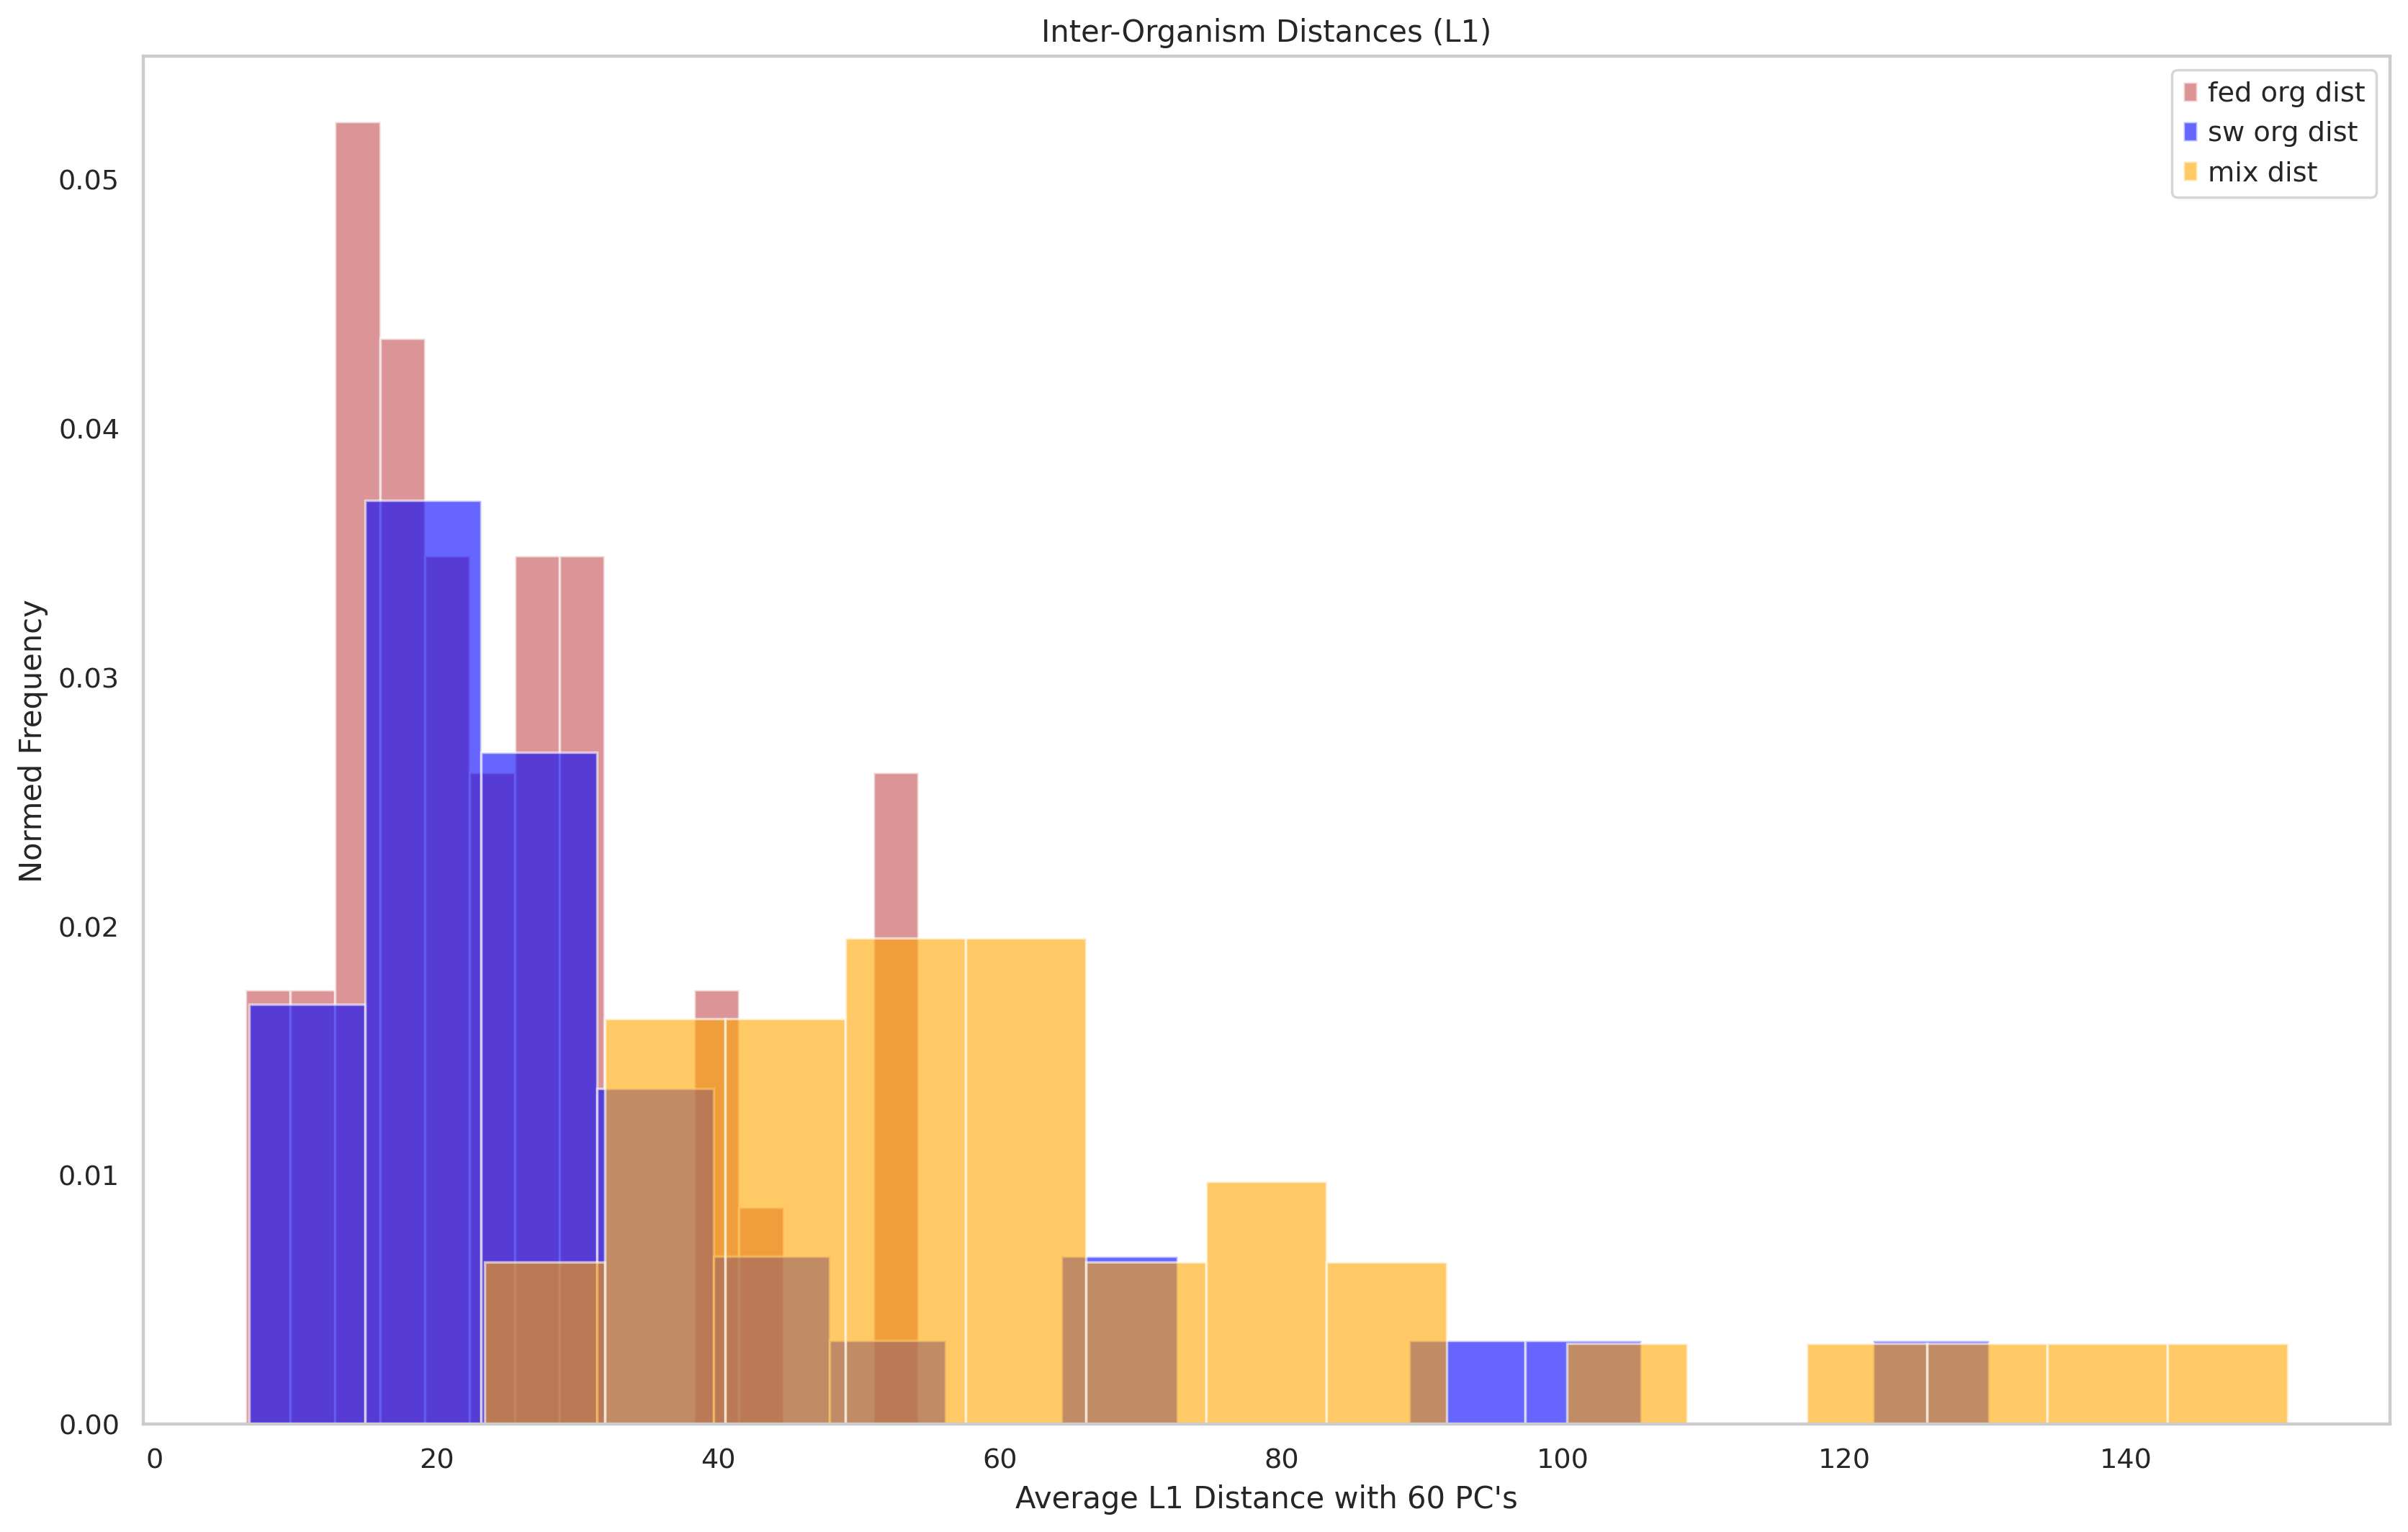

In [ ]:
plt.figure(figsize=(16,10))
plt.hist(org_pairDists['pair_fed'],color='r',bins=15,alpha=0.6,label='fed org dist',density=True)
plt.hist(org_pairDists['pair_sw'],color='blue',bins=15,alpha=0.6,label='sw org dist',density=True)
plt.hist(org_pairDists['pair_mix'], bins=15,color = 'orange',alpha=0.6,label='mix dist',density=True)
plt.legend(loc='upper right')
plt.title('Inter-Organism Distances (L1)')
plt.grid(b=None)
plt.xlabel("Average L1 Distance with 60 PC's")
plt.ylabel("Normed Frequency")

plt.show()